# Module 7: Using Ragas to Evaluate an Agent Application built with LangChain and LangGraph

In the following notebook, we'll be looking at how [Ragas](https://github.com/explodinggradients/ragas) can be helpful in a number of ways when looking to evaluate your Agent applications!

While this example is rooted in LangChain/LangGraph - Ragas is framework agnostic (you don't even need to be using a framework!).

We'll:

- Collect our data
- Create a simple Agent application
- Evaluate our Agent application

> NOTE: This notebook is very lightly modified from Ragas' [LangGraph tutorial](https://docs.ragas.io/en/stable/howtos/integrations/_langgraph_agent_evaluation/)!

## Outline
  - Task 1: Installing Required Libraries
  - Task 2: Set Environment Variables
  - Task 3: Building a ReAct Agent with Metal Price Tool
  - Task 4: Implementing the Agent Graph Structure
  - Task 5: Converting Agent Messages to Ragas Evaluation Format
  - Task 6: Evaluating the Agent's Performance using Ragas Metrics
  - ***Activity #1: Evaluate Tool Call Accuracy***
  - ***Activity #2: Evaluate Topic Adherence***

## Task 1: Installing Required Libraries

If you have not already done so, install the required libraries using the uv package manager:
``` bash

uv sync

```

## Task 2: Set Environment Variables:

We'll also need to provide our API keys.
> NOTE: In addition to OpenAI's models, this notebook will be creating a metals pricing tool using the API from metals.dev. Please be sure to sign up for an account on [metals.dev](https://metals.dev/) to get your API key.
You have two options for supplying your API keys in this module:
- Use environment variables (see Prerequisites in the README.md)
- Provide them via a prompt when the notebook runs

The following code will load all of the environment variables in your `.env`. Then, it checks for the two API keys we need. If they are not there, it will prompt you to provide them.

First, OpenAI's for our LLM/embedding model combination!

Second, metals.dev's for our metals pricing tool.


In [1]:
import os
from getpass import getpass
from dotenv import load_dotenv

load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")

if not os.environ.get("METAL_API_KEY"):
    os.environ["METAL_API_KEY"] = getpass("Please enter your metals.dev API key!")

## Task 3: Building a ReAct Agent with Metal Price Tool

### Define the get_metal_price Tool

The get_metal_price tool will be used by the agent to fetch the price of a specified metal. We'll create this tool using the @tool decorator from LangChain.

In [2]:
from langchain_core.tools import tool
import requests
from requests.structures import CaseInsensitiveDict
import os


# Define the tools for the agent to use
@tool
def get_metal_price(metal_name: str) -> float:
    """Fetches the current per gram price of the specified metal.

    Args:
        metal_name : The name of the metal (e.g., 'gold', 'silver', 'platinum').

    Returns:
        float: The current price of the metal in dollars per gram.

    Raises:
        KeyError: If the specified metal is not found in the data source.
    """
    try:
        metal_name = metal_name.lower().strip()
        url = f"https://api.metals.dev/v1/latest?api_key={os.environ['METAL_API_KEY']}&currency=USD&unit=toz"
        headers = CaseInsensitiveDict()
        headers["Accept"] = "application/json"
        resp = requests.get(url, headers=headers)
        print(resp)
        metal_price = resp.json()["metals"]
        if metal_name not in metal_price:
            raise KeyError(
                f"Metal '{metal_name}' not found. Available metals: {', '.join(metal_price['metals'].keys())}"
            )
        return metal_price[metal_name]
    except Exception as e:
        raise Exception(f"Error fetching metal price: {str(e)}")

### Binding the Tool to the LLM
With the get_metal_price tool defined, the next step is to bind it to the ChatOpenAI model. This enables the agent to invoke the tool during its execution based on the user's requests allowing it to interact with external data and perform actions beyond its native capabilities.

In [3]:
from langchain_openai import ChatOpenAI

tools = [get_metal_price]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

## Task 4: Implementing the Agent Graph Structure

In LangGraph, state plays a crucial role in tracking and updating information as the graph executes. As different parts of the graph run, the state evolves to reflect the changes and contains information that is passed between nodes.

For example, in a conversational system like this one, the state is used to track the exchanged messages. Each time a new message is generated, it is added to the state and the updated state is passed through the nodes, ensuring the conversation progresses logically.

### Defining the State
To implement this in LangGraph, we define a state class that maintains a list of messages. Whenever a new message is produced it gets appended to this list, ensuring that the conversation history is continuously updated.

In [4]:
from langgraph.graph import END
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Defining the should_continue Function
The `should_continue` function determines whether the conversation should proceed with further tool interactions or end. Specifically, it checks if the last message contains any tool calls (e.g., a request for metal prices).

- If the last message includes tool calls, indicating that the agent has invoked an external tool, the conversation continues and moves to the "tools" node.
- If there are no tool calls, the conversation ends, represented by the END state.

In [5]:
# Define the function that determines whether to continue or not
def should_continue(state: GraphState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

### Creating the Assistant Node
The `assistant` node is a key component responsible for processing the current state of the conversation and using the Language Model (LLM) to generate a relevant response. It evaluates the state, determines the appropriate course of action, and invokes the LLM to produce a response that aligns with the ongoing dialogue.

In [6]:
# Node
def assistant(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

### Creating the Tool Node
The `tool_node` is responsible for managing interactions with external tools, such as fetching metal prices or performing other actions beyond the LLM's native capabilities. The tools themselves are defined earlier in the code, and the tool_node invokes these tools based on the current state and the needs of the conversation.

In [7]:
from langgraph.prebuilt import ToolNode

# Node
tools = [get_metal_price]
tool_node = ToolNode(tools)

### Building the Graph
The graph structure is the backbone of the agentic workflow, consisting of interconnected nodes and edges. To construct this graph, we use the StateGraph builder which allows us to define and connect various nodes. Each node represents a step in the process (e.g., the assistant node, tool node) and the edges dictate the flow of execution between these steps.

In [8]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

# Define a new graph for the agent
builder = StateGraph(GraphState)

# Define the two nodes we will cycle between
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

# Set the entrypoint as `agent`
builder.add_edge(START, "assistant")

# Making a conditional edge
# should_continue will determine which node is called next.
builder.add_conditional_edges("assistant", should_continue, ["tools", END])

# Making a normal edge from `tools` to `agent`.
# The `agent` node will be called after the `tool`.
builder.add_edge("tools", "assistant")

# Compile and display the graph for a visual overview
react_graph = builder.compile()

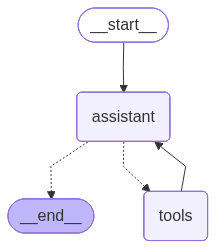

In [9]:
react_graph

To test our setup, we will run the agent with a query. The agent will fetch the price of copper using the metals.dev API.

In [10]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is the price of copper?")]
result = react_graph.invoke({"messages": messages})

<Response [200]>


In [11]:
result["messages"]

[HumanMessage(content='What is the price of copper?', additional_kwargs={}, response_metadata={}, id='9ce25a39-a5d6-4052-adde-7417b64b3f64'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 116, 'total_tokens': 134, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_373a14eb6f', 'id': 'chatcmpl-DCcW6f3XzaOwRy19YmVscbR5jHcgW', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c8d7d-ef2f-7e83-ba4d-08b34a1b5ecb-0', tool_calls=[{'name': 'get_metal_price', 'args': {'metal_name': 'copper'}, 'id': 'call_NYk3F7dcOxDqpRYRAN4CgGH4', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 116, 'output_

## Task 5: Converting Agent Messages to Ragas Evaluation Format

In the current implementation, the GraphState stores messages exchanged between the human user, the AI (LLM's responses), and any external tools (APIs or services the AI uses) in a list. Each message is an object in LangChain's format

```python
# Implementation of Graph State
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
```

Each time a message is exchanged during agent execution, it gets added to the messages list in the GraphState. However, Ragas requires a specific message format for evaluating interactions.

Ragas uses its own format to evaluate agent interactions. So, if you're using LangGraph, you will need to convert the LangChain message objects into Ragas message objects. This allows you to evaluate your AI agents with Ragas' built-in evaluation tools.

**Goal:**  Convert the list of LangChain messages (e.g., HumanMessage, AIMessage, and ToolMessage) into the format expected by Ragas, so the evaluation framework can understand and process them properly.

To convert a list of LangChain messages into a format suitable for Ragas evaluation, Ragas provides the function [convert_to_ragas_messages][ragas.integrations.langgraph.convert_to_ragas_messages], which can be used to transform LangChain messages into the format expected by Ragas.

Here's how you can use the function:

In [12]:
from ragas.integrations.langgraph import convert_to_ragas_messages

# Assuming 'result["messages"]' contains the list of LangChain messages
ragas_trace = convert_to_ragas_messages(result["messages"])

In [13]:
ragas_trace  # List of Ragas messages

[HumanMessage(content='What is the price of copper?', metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[]),
 ToolMessage(content='0.4074', metadata=None, type='tool'),
 AIMessage(content='The current price of copper is $0.4074 per gram.', metadata=None, type='ai', tool_calls=[])]

### ❓ Question #1:

Describe in your own words what a "trace" is.

##### ✅ Answer:

A trace is a listing of the steps the LLM system took to generate a final response for the user. It shows how the system processed the user's question and all of the intermediate tools calls it made in between to get to a final answer. 

## Task 6: Evaluating the Agent's Performance  using Ragas Metrics

For this tutorial, let us evaluate the Agent with the following metrics:

- [Tool call Accuracy](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/#tool-call-accuracy):ToolCallAccuracy is a metric that can be used to evaluate the performance of the LLM in identifying and calling the required tools to complete a given task.  

- [Agent Goal accuracy](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/#agent-goal-accuracy): Agent goal accuracy is a metric that can be used to evaluate the performance of the LLM in identifying and achieving the goals of the user. This is a binary metric, with 1 indicating that the AI has achieved the goal and 0 indicating that the AI has not achieved the goal.
- [Topic Adherence](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/): Topic adherence is a metric that can be used to ensure the Agent system is staying "on-topic", meaning that it's not straying from the intended use case. You can think of this as a kinda of faithfulness, where the responses of the LLM should stay faithful to the topic provided.


First, let us actually run our Agent with a couple of queries, and make sure we have the ground truth labels for these queries.

### ❓ Question #2:

Describe *how* each of the above metrics are calculated. This will require you to read the documentation for each metric.

##### ✅ Answer:

**Tool Call Accuracy**: *(argument accuracy) × (sequence aligned ? 1 : 0)*<br>
*argument_accuracy*: correc parameters for each tool<br>
*sequence alignment*: correct tools in correct order
<br><br>
**Agent Goal Accuracy**: compare workflow end state against a provided reference outcome or the LLM's estimation of what the input users goal was
<br><br>
**Topic Adherence**: can be measured with respect to precision, recall or an F1 score that takes both into account<br>
(*equations shown below*)

In [20]:
from IPython.display import Math
Math(r"\text{Precision} = \frac{|\text{Queries answered that adhere to any reference topics}|}{|\text{Queries answered that adhere to any reference topics}| + |\text{Queries answered that do not adhere to any reference topics}|}")

<IPython.core.display.Math object>

In [22]:
Math(r"\text{Recall} = \frac{|\text{Queries answered that adhere to any reference topics}|}{|\text{Queries answered that adhere to any reference topics}| + |\text{Queries refused that should have been answered}|}")

<IPython.core.display.Math object>

### Tool Call Accuracy

In [40]:
from ragas.metrics import ToolCallAccuracy
from ragas.dataset_schema import MultiTurnSample
from ragas.integrations.langgraph import convert_to_ragas_messages
import ragas.messages as r


ragas_trace = convert_to_ragas_messages(
    messages=result["messages"]
)  # List of Ragas messages converted using the Ragas function

# Patch tool_calls: convert_to_ragas_messages reads from additional_kwargs which
# is empty in newer LangChain versions. Copy tool_calls from the original messages.
for lc_msg, ragas_msg in zip(result["messages"], ragas_trace):
    if hasattr(lc_msg, "tool_calls") and lc_msg.tool_calls and hasattr(ragas_msg, "tool_calls"):
        ragas_msg.tool_calls = [
            r.ToolCall(name=tc["name"], args=tc["args"]) for tc in lc_msg.tool_calls
        ]

sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_tool_calls=[
        r.ToolCall(name="get_metal_price", args={"metal_name": "copper"})
    ],
)

tool_accuracy_scorer = ToolCallAccuracy()
tool_accuracy_scorer.llm = ChatOpenAI(model="gpt-4o-mini")
await tool_accuracy_scorer.multi_turn_ascore(sample)

0.0

### Agent Goal Accuracy

In [24]:
messages = [HumanMessage(content="What is the price of 10 grams of silver?")]

result = react_graph.invoke({"messages": messages})

<Response [200]>


In [25]:
result["messages"]  # List of Langchain messages

[HumanMessage(content='What is the price of 10 grams of silver?', additional_kwargs={}, response_metadata={}, id='b364a989-8e54-4534-b0fd-edeb5e7a9275'),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 120, 'total_tokens': 137, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_373a14eb6f', 'id': 'chatcmpl-DCcnPThL0dfMEFjlaGzqFEbZF1eeu', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c8d8e-4da4-7692-b26b-a1be9c972182-0', tool_calls=[{'name': 'get_metal_price', 'args': {'metal_name': 'silver'}, 'id': 'call_n0O7DfBRjune6UXl5EIWqjWt', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 1

In [26]:
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(
    result["messages"]
)  # List of Ragas messages converted using the Ragas function
ragas_trace

[HumanMessage(content='What is the price of 10 grams of silver?', metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[]),
 ToolMessage(content='87.4185', metadata=None, type='tool'),
 AIMessage(content='The current price of silver is approximately $87.42 per gram. Therefore, the price for 10 grams of silver would be about $874.18.', metadata=None, type='ai', tool_calls=[])]

In [27]:
from ragas.dataset_schema import MultiTurnSample
from ragas.metrics import AgentGoalAccuracyWithReference
from ragas.llms import LangchainLLMWrapper


sample = MultiTurnSample(
    user_input=ragas_trace,
    reference="Price of 10 grams of silver",
)

scorer = AgentGoalAccuracyWithReference()

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
scorer.llm = evaluator_llm
await scorer.multi_turn_ascore(sample)

1.0

Agent Goal Accuracy: 1, because the LLM correctly achieved the user's goal of retrieving the price of 10 grams of silver.

### Topic Adherence


In [28]:
messages = [HumanMessage(content="How fast can an eagle fly?")]

result = react_graph.invoke({"messages": messages})

In [29]:
result["messages"]

[HumanMessage(content='How fast can an eagle fly?', additional_kwargs={}, response_metadata={}, id='d53a2e5c-eb1f-4754-96eb-ecf3f586b9b0'),
 AIMessage(content='Eagles are known for their impressive flying abilities. Depending on the species, eagles can fly at different speeds:\n\n1. **Bald Eagle**: They typically fly at speeds of 30 to 35 miles per hour (48 to 56 kilometers per hour) when cruising, but can reach speeds of up to 40 miles per hour (64 kilometers per hour) when diving.\n\n2. **Golden Eagle**: This species is even faster and can reach speeds of 75 miles per hour (121 kilometers per hour) in a dive and fly at speeds of around 28 to 32 miles per hour (45 to 51 kilometers per hour) during level flight.\n\nOverall, while cruising speeds are generally moderate, the diving speeds during hunting are particularly fast, showcasing their agility and hunting prowess.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 162, 'prompt_tokens': 1

In [30]:
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(
    result["messages"]
)  # List of Ragas messages converted using the Ragas function
ragas_trace

[HumanMessage(content='How fast can an eagle fly?', metadata=None, type='human'),
 AIMessage(content='Eagles are known for their impressive flying abilities. Depending on the species, eagles can fly at different speeds:\n\n1. **Bald Eagle**: They typically fly at speeds of 30 to 35 miles per hour (48 to 56 kilometers per hour) when cruising, but can reach speeds of up to 40 miles per hour (64 kilometers per hour) when diving.\n\n2. **Golden Eagle**: This species is even faster and can reach speeds of 75 miles per hour (121 kilometers per hour) in a dive and fly at speeds of around 28 to 32 miles per hour (45 to 51 kilometers per hour) during level flight.\n\nOverall, while cruising speeds are generally moderate, the diving speeds during hunting are particularly fast, showcasing their agility and hunting prowess.', metadata=None, type='ai', tool_calls=[])]

In [31]:
from ragas.metrics import TopicAdherenceScore

sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_topics = ["metals"]
)

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
scorer = TopicAdherenceScore(llm = evaluator_llm, mode="precision")
await scorer.multi_turn_ascore(sample)

np.float64(0.0)

As we can see, the current implementation fails due to talking about birds, when it should be talking about metal!

### ❓ Question #3:

If you were deploying this metal price agent as a production wellness assistant (imagine it's a financial wellness tool for tracking investment metals), what are the implications of each metric (Tool Call Accuracy, Agent Goal Accuracy, Topic Adherence) for user trust and safety?

##### ✅ Answer:

- **Tool Call Accuracy**: wrong answers will be given if the wrong tools are used, decreasing trust and credebility<br>
- **Agent Goal Accuracy**: if the agent doesn't meet its goal, money won't be given to keep it running, or it will be replaced with something cheaper or easier to use<br>
- **Topic Adherence**: if required topics aren't adhered to, there could be detrimental privacy implications, or a breach of trust between the human and AI system

### ❓ Question #4:

How would you design a comprehensive test suite for evaluating this metal price agent? What test cases would you include to ensure robustness across the three metrics (Tool Call Accuracy, Agent Goal Accuracy, Topic Adherence)?

##### ✅ Answer:

- **Tool Call Accuracy**:
    - ask questions that you know require the lookup of realtime metal spot prices
    - ask questions that you know definitely don't require that metal spot price lookup
- **Agent Goal Accuracy**:
    - give the LLM questions that you know it should answer correctly based on its goal
    - give questions that tangentially align with its goal, and see if it still meets at least part of its requirements in answering them
    - give far out questions that are not at all related to its goal and see what it does
- **Topic Adherence**:
    - give questions partially on topic, very on topic and not on topic at all, and compare how it answers them
    - give questions that touch upon multiple topics, only one of which the relevant topic
    - give a question where most of the parts of it are on topic but exactly one part is off topic, and see if it ignore that one off-topic part

## Activity #1: Evaluate Tool Call Accuracy with a New Query

Create a new test case for Tool Call Accuracy. Run the agent with a different metal query (e.g., "What is the price of platinum?") and evaluate its tool call accuracy.

**Requirements:**
1. Create a new query for the agent
2. Run the agent and collect the trace
3. Define the expected reference tool calls
4. Evaluate using ToolCallAccuracy
5. Document your results

In [41]:
# 1. Create a new query
messages = [HumanMessage(content="What is the price of platinum?")]

# 2. Run the agent
result = react_graph.invoke({"messages": messages})

# 3. Convert to Ragas format
ragas_trace = convert_to_ragas_messages(result["messages"])

# Patch tool_calls: convert_to_ragas_messages reads from additional_kwargs which
# is empty in newer LangChain versions. Copy tool_calls from the original messages.
for lc_msg, ragas_msg in zip(result["messages"], ragas_trace):
    if hasattr(lc_msg, "tool_calls") and lc_msg.tool_calls and hasattr(ragas_msg, "tool_calls"):
        ragas_msg.tool_calls = [
            r.ToolCall(name=tc["name"], args=tc["args"]) for tc in lc_msg.tool_calls
        ]

# 4. Create MultiTurnSample with reference_tool_calls
sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_tool_calls=[
        r.ToolCall(name="get_metal_price", args={"metal_name": "platinum"})
    ],
)

# 5. Evaluate with ToolCallAccuracy
tool_accuracy_scorer = ToolCallAccuracy()
tool_accuracy_scorer.llm = ChatOpenAI(model="gpt-4o-mini")
await tool_accuracy_scorer.multi_turn_ascore(sample)

<Response [200]>


1.0

## Activity #2: Evaluate Topic Adherence with an On-Topic Query

Create a test case that should PASS the Topic Adherence check. Run the agent with a metals-related query and verify it stays on topic.

**Requirements:**
1. Create a metals-related query for the agent
2. Run the agent and collect the trace
3. Create a MultiTurnSample with reference_topics=["metals"]
4. Evaluate using TopicAdherenceScore
5. The score should be 1.0 (or close to it) since the query is on-topic

In [49]:
# 1. Create a metals-related query
messages = [HumanMessage(content="What is the current price of gold?")]

# 2. Run the agent
result = react_graph.invoke({"messages": messages})

# 3. Convert to Ragas format
ragas_trace = convert_to_ragas_messages(result["messages"])

# Filter out empty AIMessages and their associated ToolMessages (tool-calling
# steps produce empty AIMessages which the scorer flags as off-topic, and
# ToolMessages must be preceded by an AIMessage per Ragas validation)
import ragas.messages as r
ragas_trace = [
    msg for msg in ragas_trace
    if not isinstance(msg, r.ToolMessage)
    and not (isinstance(msg, r.AIMessage) and not msg.content)
]

# 4. Create MultiTurnSample with reference_topics=["metals"]
sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_topics=["metals"],
)

# 5. Evaluate with TopicAdherenceScore
# Note: gpt-4o-mini misjudges this as off-topic; gpt-4o correctly identifies it as on-topic
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
scorer = TopicAdherenceScore(llm=evaluator_llm, mode="precision")
await scorer.multi_turn_ascore(sample)

<Response [200]>


np.float64(0.9999999999)